<a href="https://colab.research.google.com/github/oviccenzo/trabalho-de-analise-de-algoritmo/blob/main/trabalho_de_analises_de_algoritmo_e_algoritmo_de_ordenacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Gerando instância aleatória n=10
  Testando bubble ... 8.956000002058317e-06 s
  Testando selection ... 1.0367999990990029e-05 s
  Testando insertion ... 6.3869999991084114e-06 s
  Testando merge ... 2.0929000001501663e-05 s
  Testando quick ... 1.2484000009749252e-05 s
  Testando heap ... 1.547399999424215e-05 s
  Testando shell ... 6.772999995519058e-06 s
  Testando timsort ... 1.5720000021701708e-06 s

Gerando instância aleatória n=100
  Testando bubble ... 0.0010059399999988727 s
  Testando selection ... 0.0003522909999986723 s
  Testando insertion ... 0.0003259599999978491 s
  Testando merge ... 0.0002871780000077706 s
  Testando quick ... 0.00019459000000665583 s
  Testando heap ... 0.00026317900000094596 s
  Testando shell ... 0.00012524100000632643 s
  Testando timsort ... 1.2284999996836632e-05 s

Gerando instância aleatória n=1000
  Testando bubble ...

usage: colab_kernel_launcher.py [-h] [--out OUT_DIR] [--repeats REPEATS]
                                [--skip-quadratic-above SKIP_QUAD]
                                [--sizes SIZES] [--no-plot]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-abebf8c0-79b3-47c1-9e5c-ef80593c8edd.json


 0.10745288600000436 s
  Testando selection ... 0.04693786299999658 s
  Testando insertion ... 0.045110213000000954 s
  Testando merge ... 0.0034909230000010893 s
  Testando quick ... 0.0026558650000083617 s
  Testando heap ... 0.004733381999997732 s
  Testando shell ... 0.0036852369999991197 s
  Testando timsort ... 0.00016547999999261265 s

Gerando instância aleatória n=5000
  Testando bubble ... 3.4063099569999906 s
  Testando selection ... 0.6297704739999972 s
  Testando insertion ... 0.6050224530000037 s
  Testando merge ... 0.012344611999992594 s
  Testando quick ... 0.009099387999995656 s
  Testando heap ... 0.014862316999995073 s
  Testando shell ... 0.01468068900000219 s
  Testando timsort ... 0.0010817569999943544 s

Gerando instância aleatória n=10000
  Testando bubble ... 6.967930635000002 s
  Testando selection ... 2.6330616929999877 s
  Testando insertion ... 2.4689432469999986 s
  Testando merge ... 0.026232270000008384 s
  Testando quick ... 0.019536203999990676 s
  Tes

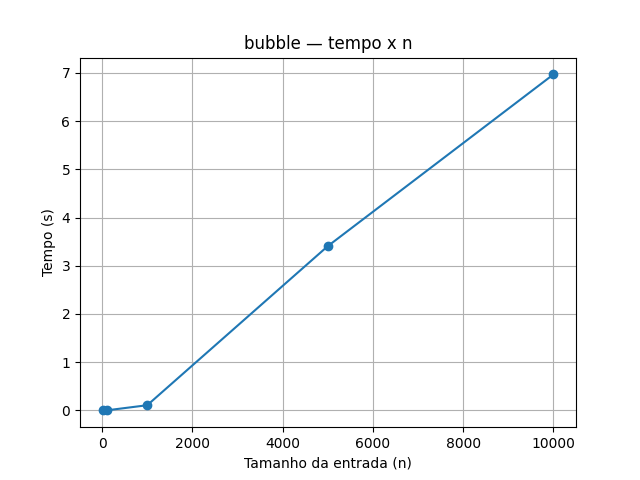

  Exibindo: quick_time.png


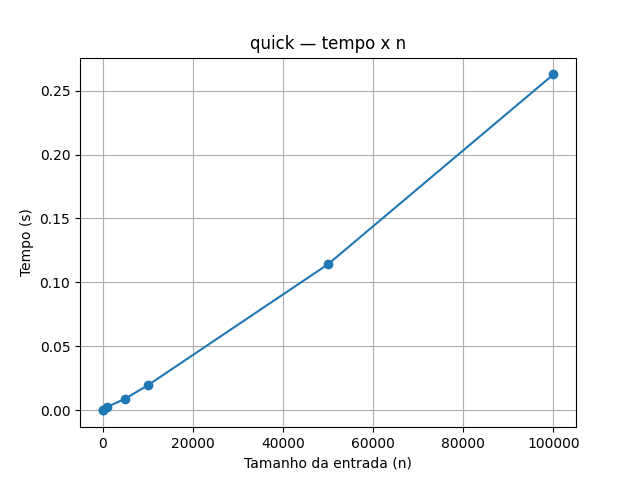

  Exibindo: selection_time.png


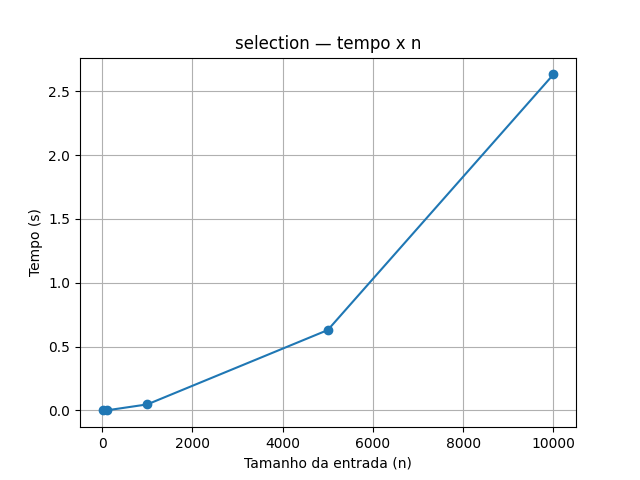

  Exibindo: heap_time.png


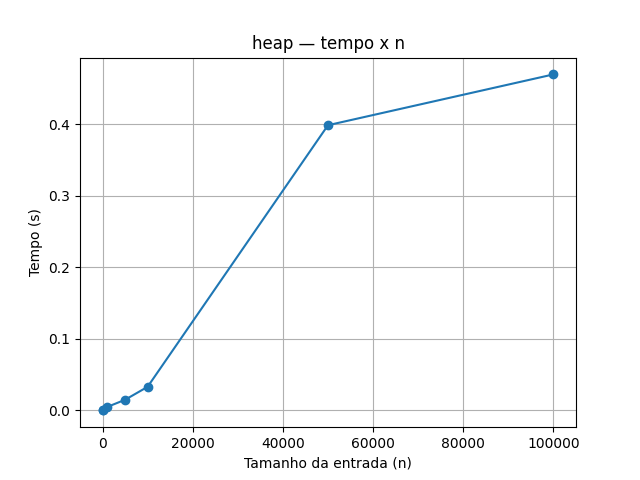

  Exibindo: comparativo_time_log.png


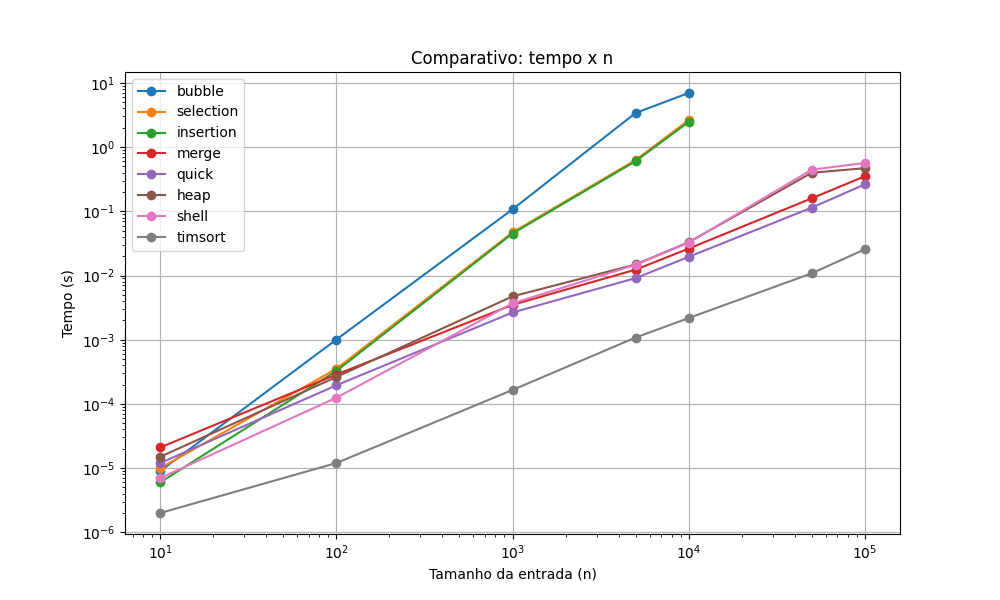

  Exibindo: insertion_time.png


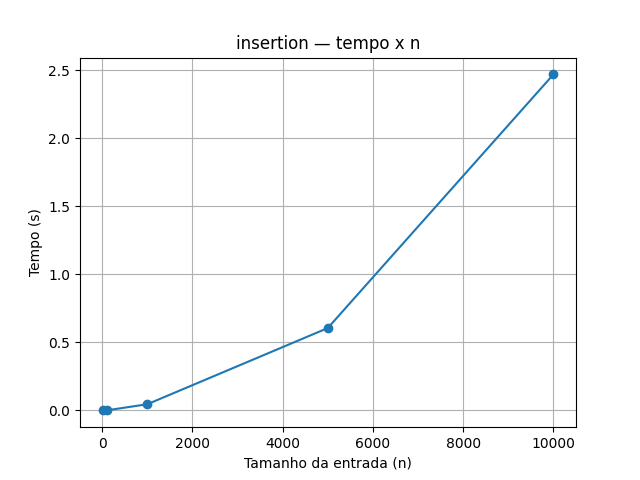

  Exibindo: timsort_time.png


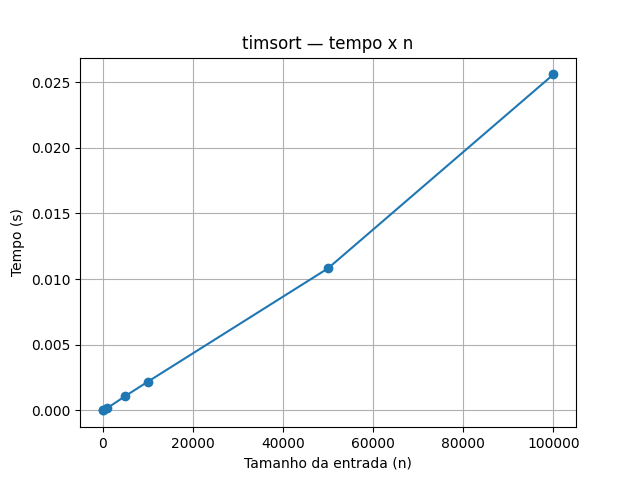

  Exibindo: comparativo_time.png


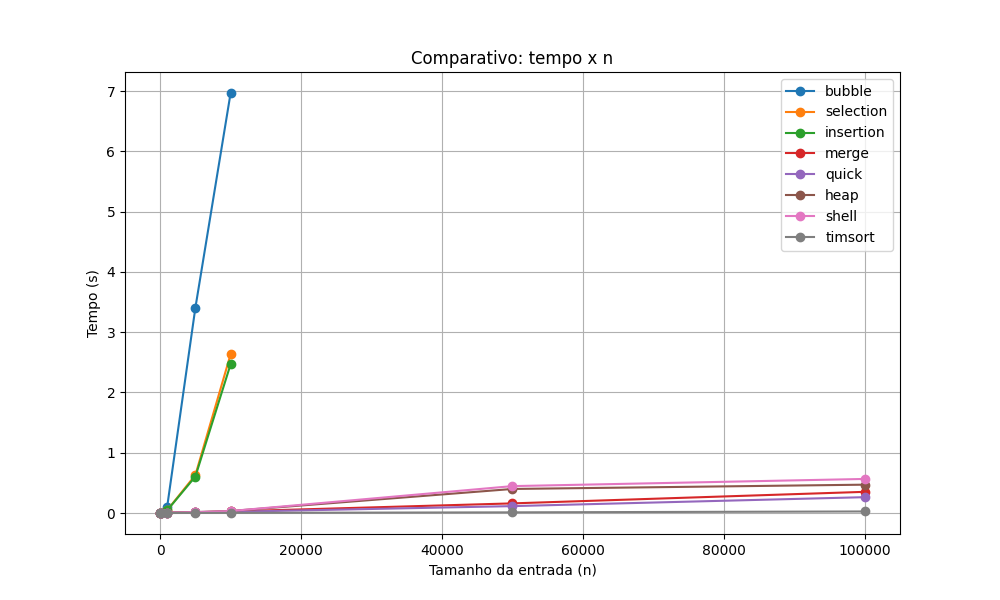

  Exibindo: merge_time.png


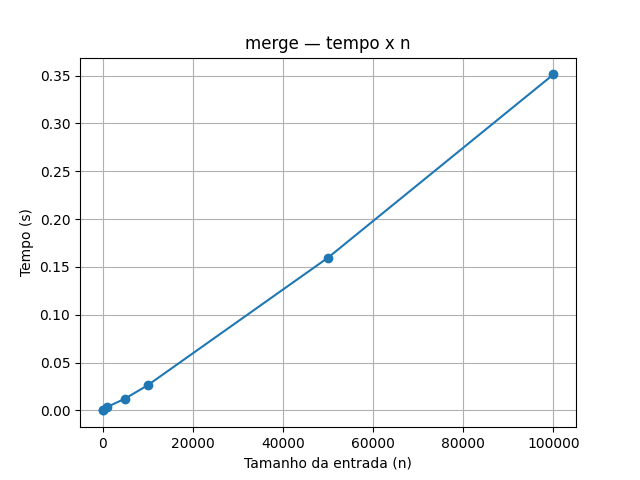

  Exibindo: shell_time.png


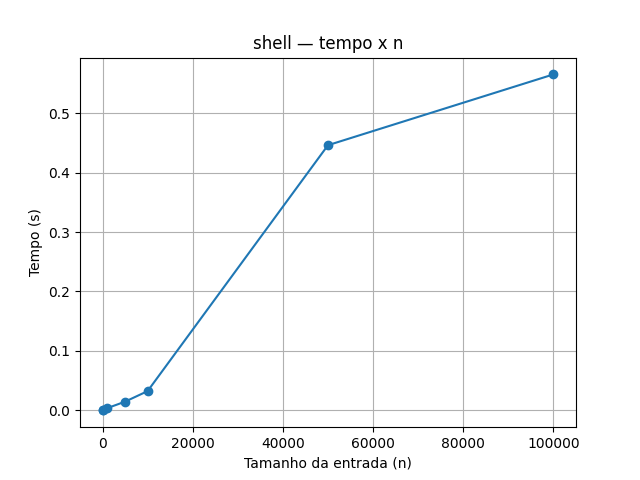


Execução finalizada. Confira o diretório de saída para CSVs e PNGs.


In [1]:
import random
import time
import argparse
import os
import csv
import sys
import math
from IPython.display import Image, display # Import Image and display

# Aumenta limite de recursão para quicksort/merge se necessário
sys.setrecursionlimit(1000000)

# ---------- Implementações dos algoritmos de ordenação ----------

def bubble_sort(arr):
    a = arr[:]  # copia para não alterar original
    n = len(a)
    for i in range(n):
        swapped = False
        for j in range(0, n - i - 1):
            if a[j] > a[j+1]:
                a[j], a[j+1] = a[j+1], a[j]
                swapped = True
        if not swapped:
            break
    return a

def selection_sort(arr):
    a = arr[:]
    n = len(a)
    for i in range(n):
        min_idx = i
        for j in range(i+1, n):
            if a[j] < a[min_idx]:
                min_idx = j
        a[i], a[min_idx] = a[min_idx], a[i]
    return a

def insertion_sort(arr):
    a = arr[:]
    for i in range(1, len(a)):
        key = a[i]
        j = i - 1
        while j >= 0 and a[j] > key:
            a[j+1] = a[j]
            j -= 1
        a[j+1] = key  # Fixed: Should be j+1, not j
    return a

def merge_sort(arr):
    a = arr[:]
    if len(a) <= 1:
        return a
    mid = len(a) // 2
    left = merge_sort(a[:mid])
    right = merge_sort(a[mid:])
    return merge(left, right)

def merge(left, right):
    result = []
    i, j = 0, 0
    while i < len(left) and j < len(right):
        if left[i] <= right[j]:
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            j += 1
    result.extend(left[i:])
    result.extend(right[j:])
    return result

def quick_sort(arr):
    a = arr[:]
    if len(a) <= 1:
        return a
    pivot = a[len(a) // 2]
    left = [x for x in a if x < pivot]
    middle = [x for x in a if x == pivot]
    right = [x for x in a if x > pivot]
    return quick_sort(left) + middle + quick_sort(right)

def heap_sort(arr):
    a = arr[:]
    n = len(a)
    def heapify(arr, n, i):
        largest = i
        l = 2 * i + 1
        r = 2 * i + 2
        if l < n and arr[l] > arr[largest]:
            largest = l
        if r < n and arr[r] > arr[largest]:
            largest = r
        if largest != i:
            arr[i], arr[largest] = arr[largest], arr[i]
            heapify(arr, n, largest)
    for i in range(n // 2 - 1, -1, -1):
        heapify(a, n, i)
    for i in range(n - 1, 0, -1):
        a[i], a[0] = a[0], a[i]
        heapify(a, i, 0)
    return a

def shell_sort(arr):
    a = arr[:]
    n = len(a)
    gap = n // 2
    while gap > 0:
        for i in range(gap, n):
            temp = a[i]
            j = i
            while j >= gap and a[j - gap] > temp:
                a[j] = a[j - gap]
                j -= gap
            a[j] = temp
        gap //= 2
    return a

def python_sort(arr):
    return sorted(arr)

# Mapas
ALGORITHMS = {
    "bubble": bubble_sort,
    "selection": selection_sort,
    "insertion": insertion_sort,
    "merge": merge_sort,
    "quick": quick_sort,
    "heap": heap_sort,
    "shell": shell_sort,
    "timsort": python_sort
}

# ---------- Funções de medição ----------

def time_function(func, arr, repeats=3, check_sorted=True):
    """
    Executa func(arr) 'repeats' vezes com cópias independentes e retorna o tempo médio (mediana).
    check_sorted: valida que o resultado está ordenado (gera exceção se não estiver).
    """
    times = []
    for _ in range(repeats):
        a = arr[:]  # cópia
        t0 = time.perf_counter()
        out = func(a)
        t1 = time.perf_counter()
        elapsed = t1 - t0
        times.append(elapsed)
        if check_sorted:
            # valida ordenação
            if out != sorted(arr):
                raise ValueError(f"Algoritmo {func.__name__} não ordenou corretamente.")
    # usar mediana para reduzir ruído
    times.sort()
    mid = times[len(times)//2]
    return mid

# ---------- Rodar experimentos ----------

DEFAULT_SIZES = [10, 100, 1000, 5000, 10000, 50000, 100000]

def run_experiments(out_dir, sizes=None, repeats=3, skip_quadratic_above=10000):
    if sizes is None:
        sizes = DEFAULT_SIZES
    os.makedirs(out_dir, exist_ok=True)
    results_csv = os.path.join(out_dir, "results.csv")
    fieldnames = ["algorithm", "n", "time_seconds"]
    with open(results_csv, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for n in sizes:
            print(f"\nGerando instância aleatória n={n}")
            base = [random.randint(0, 10**9) for _ in range(n)]
            for name, func in ALGORITHMS.items():
                # Skip heavy algorithms for big n
                if name in ("bubble", "insertion", "selection") and n > skip_quadratic_above:
                    print(f"  {name}: pulado para n={n} (muito lento).")
                    continue
                print(f"  Testando {name} ...", end="", flush=True)
                try:
                    t = time_function(func, base, repeats=repeats)
                except Exception as e:
                    print(f" ERRO: {e}")
                    t = None
                print(f" {t if t is not None else 'falha'} s")
                if t is not None:
                    writer.writerow({"algorithm": name, "n": n, "time_seconds": f"{t:.6f}"})
    print(f"\nResultados salvos em: {results_csv}")
    return results_csv

# ---------- Plotagem (gera PNGs) ----------
import matplotlib.pyplot as plt

def plot_individual(csv_path, out_dir):
    # lê CSV
    data = {}
    with open(csv_path, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            alg = row["algorithm"]
            n = int(row["n"])
            t = float(row["time_seconds"])
            data.setdefault(alg, []).append((n,t))
    # Plota cada algoritmo em gráfico próprio
    for alg, pairs in data.items():
        pairs.sort()
        ns = [p[0] for p in pairs]
        ts = [p[1] for p in pairs]
        plt.figure()
        plt.plot(ns, ts, marker='o')
        plt.xlabel("Tamanho da entrada (n)")
        plt.ylabel("Tempo (s)")
        plt.title(f"{alg} — tempo x n")
        plt.grid(True)
        out_png = os.path.join(out_dir, f"{alg}_time.png")
        plt.savefig(out_png)
        plt.close()
        print(f"  Gerado: {out_png}")

def plot_comparative(csv_path, out_dir, log_scale=False):
    data = {}
    with open(csv_path, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            alg = row["algorithm"]
            n = int(row["n"])
            t = float(row["time_seconds"])
            data.setdefault(alg, []).append((n,t))
    plt.figure(figsize=(10,6))
    for alg, pairs in data.items():
        pairs.sort()
        ns = [p[0] for p in pairs]
        ts = [p[1] for p in pairs]
        plt.plot(ns, ts, marker='o', label=alg)
    plt.xlabel("Tamanho da entrada (n)")
    plt.ylabel("Tempo (s)")
    plt.title("Comparativo: tempo x n")
    plt.legend()
    plt.grid(True)
    if log_scale:
        plt.xscale("log")
        plt.yscale("log")
    out_png = os.path.join(out_dir, f"comparativo_time{'_log' if log_scale else ''}.png")
    plt.savefig(out_png)
    plt.close()
    print(f"  Gerado: {out_png}")

# ---------- CLI ----------

def parse_args():
    p = argparse.ArgumentParser(description="Experimentos empíricos de algoritmos de ordenação")
    p.add_argument("--out", dest="out_dir", default="results", help="diretório de saída")
    p.add_argument("--repeats", dest="repeats", type=int, default=3, help="repetições por teste (median)")
    p.add_argument("--skip-quadratic-above", dest="skip_quad", type=int, default=10000,
                   help="pula algoritmos O(n^2) acima deste n para evitar travar")
    p.add_argument("--sizes", dest="sizes", default=None,
                   help="tamanhos separados por vírgula, ex: 10,100,1000")
    p.add_argument("--no-plot", dest="no_plot", action="store_true", help="não gerar gráficos")
    # Add a try-except block to handle the SystemExit from parse_args in Colab
    try:
        args = p.parse_args()
    except SystemExit:
        # This handles the case where Colab passes unexpected arguments.
        # We'll parse known arguments and ignore others.
        args, unknown = p.parse_known_args()
        print(f"Warning: Ignoring unknown arguments: {unknown}")
    return args


def main():
    args = parse_args()
    if args.sizes:
        sizes = [int(x) for x in args.sizes.split(",")]
    else:
        sizes = DEFAULT_SIZES
    out_dir = args.out_dir
    os.makedirs(out_dir, exist_ok=True)
    csv_path = run_experiments(out_dir, sizes=sizes, repeats=args.repeats, skip_quadratic_above=args.skip_quad)
    if not args.no_plot:
        plot_individual(csv_path, out_dir)
        plot_comparative(csv_path, out_dir, log_scale=False)
        plot_comparative(csv_path, out_dir, log_scale=True)

        # Display generated images
        print("\nExibindo gráficos gerados:")
        for filename in os.listdir(out_dir):
            if filename.endswith(".png"):
                print(f"  Exibindo: {filename}")
                display(Image(filename=os.path.join(out_dir, filename)))

    print("\nExecução finalizada. Confira o diretório de saída para CSVs e PNGs.")

main()
